In [1]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'
from fastai.vision.all import *

In [2]:
timm.__version__

'0.6.2.dev0'

In [3]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')

In [4]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = "1"

## WT9 

- attempt to use larger models ith gradient accumulation


## Using different architectures and image transforms

In [5]:
path

Path('/notebooks/paddy/data')

In [6]:
train_path = path/'train_images'
# train_files = get_image_files(train_path).sorted()
test_files = get_image_files(path/'test_images').sorted()
tta_res = list()

{'bs': 64}


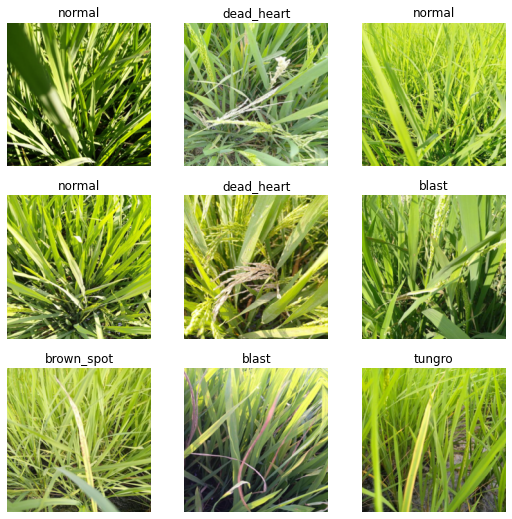

In [7]:
accum = False
kwargs = {'bs':32} if accum else {'bs':64}
print(kwargs)
item=Resize(480, method='squish')
batch=aug_transforms(size=224, min_scale=0.75)
dls = ImageDataLoaders.from_folder(train_path, valid_pct=.2, 
                                   item_tfms=item, batch_tfms=batch,
                                   **kwargs)
dls.show_batch()

In [8]:
# WT 10 - 46 min- using Jeremy code for grad accumulation

def train(desc, arch, item, batch, accum=False):
    kwargs = {'bs':32} if accum else {'bs': 64}
    # run a different subset everytime
    # we compared arch in prior nb, now we need best model
    # now diff arch, diff resize meth
    dls = ImageDataLoaders.from_folder(train_path, valid_pct=.2, 
                                       item_tfms=item, batch_tfms=batch,
                                       **kwargs)
    # only zero the gradient every 2 iters
    # matematiclly is the same
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(12, .01)
    tta_res.append(learn.tta(dl=dls.test_dl(test_files)))
    learn.export(f"{arch}_{desc}")

### Convnext small

In [9]:
ImageDataLoaders.from_folder??

Signature:
ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    valid_pct=None,
    seed=None,
    vocab=None,
    item_tfms=None,
    batch_tfms=None,
    img_cls=<class 'fastai.vision.core.PILImage'>,
    *,
    bs: 'int' = 64,
    val_bs: 'int' = None,
    shuffle: 'bool' = True,
    device=None,
)
Source:   
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, img_cls=PILImage, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock(img_cls), Categ

In [ ]:
# run out of mem
arch = 'convnext_large_in22k'
train('squish', arch, 
      item=Resize(480, method='squish'), batch=aug_transforms(size=224, min_scale=0.75))

In [ ]:
# able to run it if grad accum 
arch = 'convnext_large_in22k'
train('squish', arch,
      item=Resize(480, method='squish'), 
      batch=aug_transforms(size=224, min_scale=0.75),
      accum=True)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.003997,0.777602,0.202307,10:35


epoch,train_loss,valid_loss,error_rate,time
0,0.372468,0.235504,0.065834,22:48


In [ ]:
save_pickle('tta_res.pkl', tta_res)
tta_prs = first(zip(*tta_res)) # explore

In [ ]:
# tta_prs += tta_prs[3:5]  # clunky weighted averae over weighting best models 7
# t_tta = torch.stack(tta_prs)
# avg_pr = t_tta.mean(0)
# idx = avg_pr.argmax(dim=1)
# idx.shape
# then submit as before  

In [ ]:
tta_res[0][0].shape

In [ ]:
tta_res[0]#[0][0]

In [ ]:
test_files

## WT 11 - completed 

Videos notes

- fast.ai starter pack nb in kaggle - good one to follow -> radek1
- check out ilovescience aka tanlikesmath notebooks -> gret content and some nlp
- weights and bias intro from 10 min -> tcalelle/fastai_timm -> jeremy repo -> reat api to run experiments 
- from 31 jeremy heuristics of not using a massive hyperparam sweep but instead target experimentation and being intentional given problem at hand. This is more a computer viz appraoch, not so much for tabular.
- sheel command -> bash job control commands
    - tmux ls for tmux sessions ; 
    - ps waux | grep jupyter -> find jupyter processes, 
    - jobs , fg->foreground; ctrl+z -> stops and moves to background
    - add an '&' to the end of a command ie jl & will make it run in the background
- JH view into experiments 48 -> follow 
